In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from node2vec import Node2Vec 
import umap
import fonctions
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

In [2]:
def creer_graphe_twitter(fichier_liens):

    print(f"Chargement des liens depuis {fichier_liens}...")
    df_edges = pd.read_csv(fichier_liens)

    G = nx.from_pandas_edgelist(
        df_edges,
        source='user_id',
        target='original_author',
        edge_attr='nb_retweeted',
        create_using=nx.DiGraph()
    )

    print("-" * 30)
    print(f"Nombre de nœuds : {G.number_of_nodes()}")
    print(f"Nombre d'arêtes (retweets) : {G.number_of_edges()}")
    print("-" * 30)

    return G

In [3]:
fichier_test = 'graphe_complet_final.csv'

G = fonctions.creer_graphe_twitter(fichier_test)

Chargement des liens depuis graphe_complet_final.csv...
------------------------------
Nombre de nœuds : 144222
Nombre d'arêtes (retweets) : 216101
------------------------------


In [13]:
pds=pd.read_csv(fichier_test)
pds.head

<bound method NDFrame.head of                     user_id      original_author  nb_retweeted
0                      2986            963157886             2
1                      3634            366208117             2
2                     13621               818340             2
3                     48903  1006419421244678144             2
4                     69053            230014111             2
...                     ...                  ...           ...
216096  1501703429508386817  1006419421244678144             2
216097  1501704336946118665               759251             2
216098  1501781308481150977           2316375877             2
216099  1501880831329120261               813286             7
216100  1501918065331687427               813286             2

[216101 rows x 3 columns]>

In [4]:
# 1. On recharge les fichiers en forçant l'ID en texte (str)
df_nodes = pd.read_csv('Nodes.csv', dtype={'Id': str})
emb = pd.read_csv('embedings.csv') 

# On force la première colonne des embeddings en texte aussi
emb_col_name = emb.columns[0]
emb[emb_col_name] = emb[emb_col_name].astype(float).apply(lambda x: '{:.0f}'.format(x))

# 2. On crée le dictionnaire avec des clés en TEXTE
mapping_dict = {str(k): v for k, v in zip(df_nodes['Id'], df_nodes['modularity_class'])}

# 3. Filtrage propre
labeled = set(df_nodes['Id'].unique())
emb_labeled = emb[emb[emb_col_name].isin(labeled)].reset_index(drop=True)

# 4. Dans ta boucle de mapping
y_list = []
liste_emb_filtered = emb_labeled.values.tolist()
train, test = train_test_split(liste_emb_filtered, test_size=0.20, random_state=42)

for row in train:
    # On transforme l'ID en texte exact, sans virgule ni "e"
    val = '{:.0f}'.format(float(row[0]))
    y_list.append(mapping_dict.get(val, -1))

# 5. Conversion finale pour le KNN (les opinions sont des petits chiffres, donc int64 est OK ici)
train_opinions_np = np.array(y_list, dtype=np.int64)

In [5]:
train_opinions_np

array([0, 4, 4, 0, 4, 0, 4, 4, 0, 4, 0, 4, 4, 0, 0, 4, 0, 0, 4, 0, 4, 4,
       0, 0, 4, 4, 4, 4, 0, 0, 0, 4, 4, 0, 4, 4, 4, 4, 0, 4, 0, 0, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 0, 4, 4, 4, 0, 4,
       4, 0, 0, 4, 4, 4, 0, 0, 0, 4, 4, 0, 0, 0, 4, 4, 4, 0, 4, 0, 4, 4,
       4, 0, 4, 0, 4, 0, 4, 0, 0, 0, 0, 4, 4, 0, 0, 4, 0, 4, 4, 0, 4, 4,
       4, 4, 0, 4, 0, 4, 0, 4, 4, 4, 4, 4, 4, 0, 0, 4, 4, 4, 0, 4, 0, 4,
       4, 4, 4, 4, 4, 4, 0, 4, 0, 0, 4, 4, 4, 0, 0, 4, 0, 0, 0, 4, 4, 4,
       4, 0, 4, 0, 4, 4, 0, 0, 4, 4, 0, 4, 0, 4, 4, 0, 4, 0, 0, 4, 4, 4,
       4, 0, 0, 4, 4, 0, 4, 0, 0, 0, 4, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4,
       0, 0, 0, 4, 0, 4, 4, 0, 4, 4, 4, 0, 0, 4, 4, 0, 0, 4, 4, 4, 0, 0,
       4, 0, 4, 4, 4, 4, 4, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 4,
       0, 4, 4, 4, 4, 0, 0, 4, 4, 4, 0, 0, 4, 4, 4, 0, 0, 4, 4, 0, 0, 0,
       4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 0, 0, 0, 4, 4, 4, 0, 4,
       4, 4, 0, 4, 0, 4, 0, 0, 4, 4, 0, 4, 0, 0, 0,

In [6]:
# On crée des versions sans la colonne ID (qui est à l'indice 0)
train_ = [row[1:] for row in train]
test_ = [row[1:] for row in test]
#apprentissage non supervisé
reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    random_state=42
)

# Apprentissage sur la population de 80% avec non supervision
train_embedding = reducer.fit_transform(train_)
test_emb=reducer.transform(test_)

/home/bourenane/.local/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [7]:
y_list_test = []


for row in test:
    # On transforme l'ID en texte exact, sans virgule ni "e"
    val = '{:.0f}'.format(float(row[0]))
    y_list_test.append(mapping_dict.get(val, -1))

# 3. CRUCIAL : Convertir en tableau NumPy avec un type numérique précis (int64)
test_opinions_np = np.array(y_list_test, dtype=np.int64)

In [20]:
node_id[0]

'123504748'

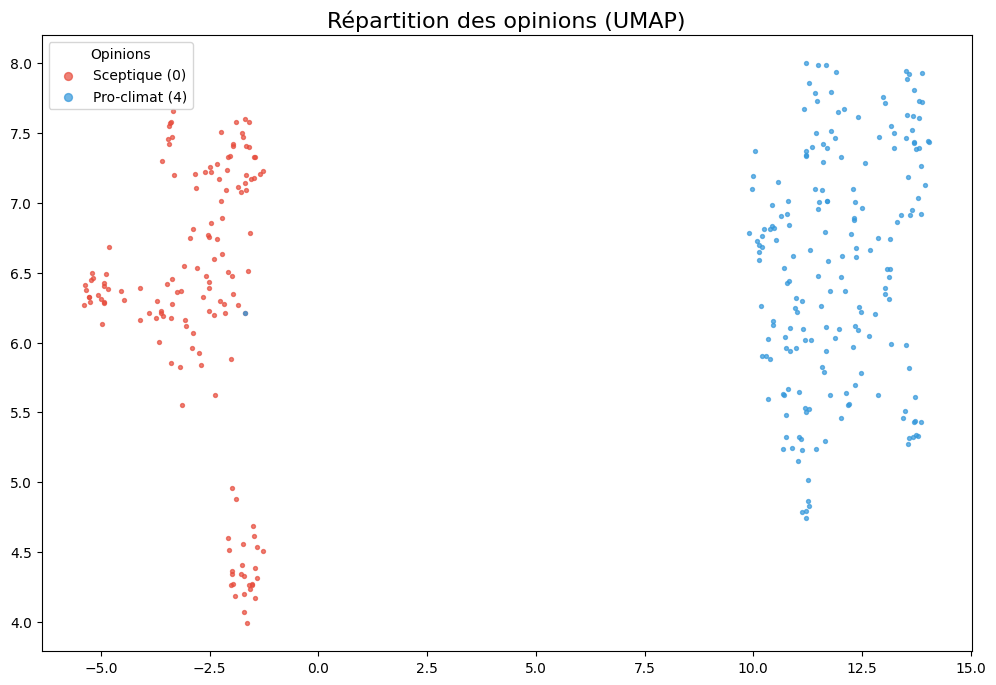

In [13]:
#suppervisé (le train)
fonctions.plot_umap_results(train_embedding,train_opinions_np)

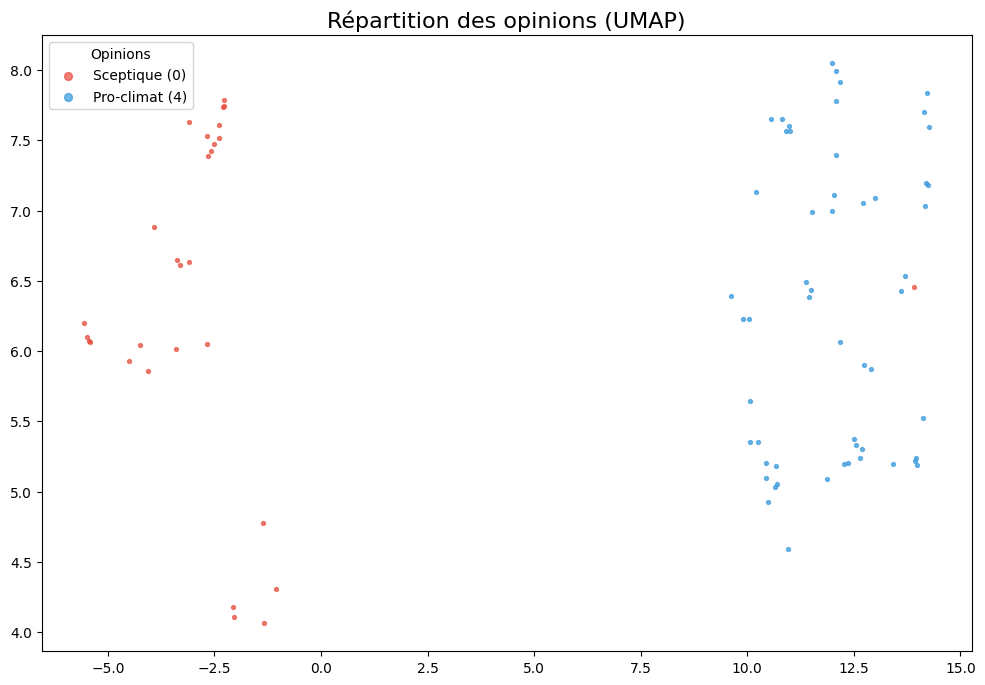

In [9]:
fonctions.plot_umap_results(test_emb,test_opinions_np)

In [10]:
# Test KNN sur UMAP Non-Supervisé
knn_unsup = KNeighborsClassifier(n_neighbors=5)
knn_unsup.fit(train_embedding, train_opinions_np)
y_pred_unsup = knn_unsup.predict(test_emb)

print("--- RÉSULTATS UMAP NON-SUPERVISÉ ---")
print(f"Accuracy: {accuracy_score(test_opinions_np, y_pred_unsup):.4f}")
print(classification_report(test_opinions_np, y_pred_unsup))

--- RÉSULTATS UMAP NON-SUPERVISÉ ---
Accuracy: 0.9881
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        29
           4       0.98      1.00      0.99        55

    accuracy                           0.99        84
   macro avg       0.99      0.98      0.99        84
weighted avg       0.99      0.99      0.99        84



In [11]:
#apprentissage supervisé
reducersupp = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    random_state=42,
    target_weight=0.5  
)
train_embeddingsupp = reducersupp.fit_transform(train_,y=train_opinions_np)
test_embsupp=reducersupp.transform(test_)


/home/bourenane/.local/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


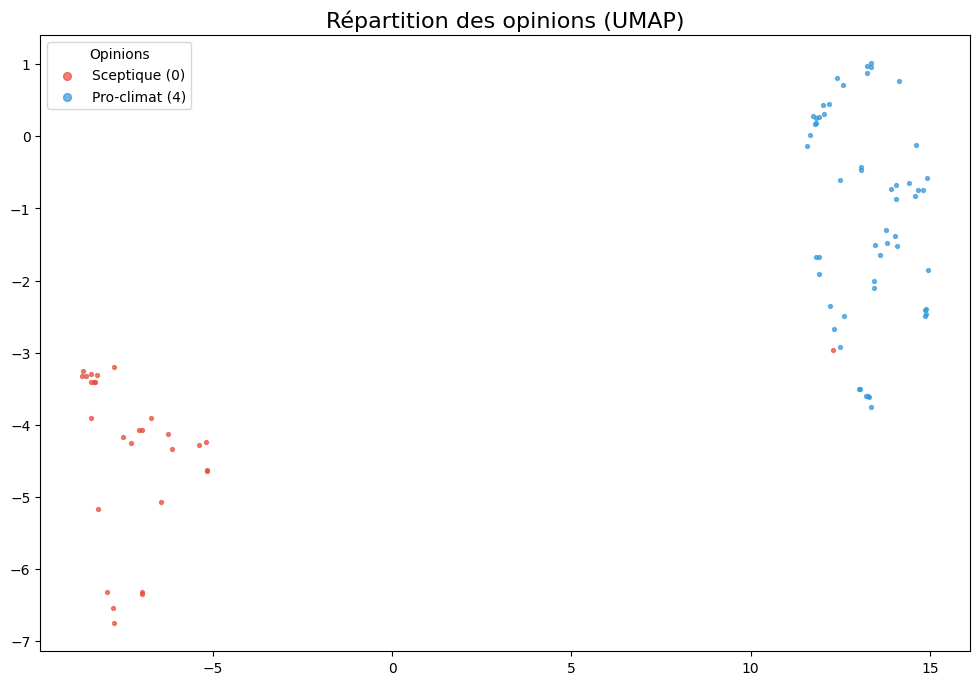

In [12]:
fonctions.plot_umap_results(test_embsupp,test_opinions_np)

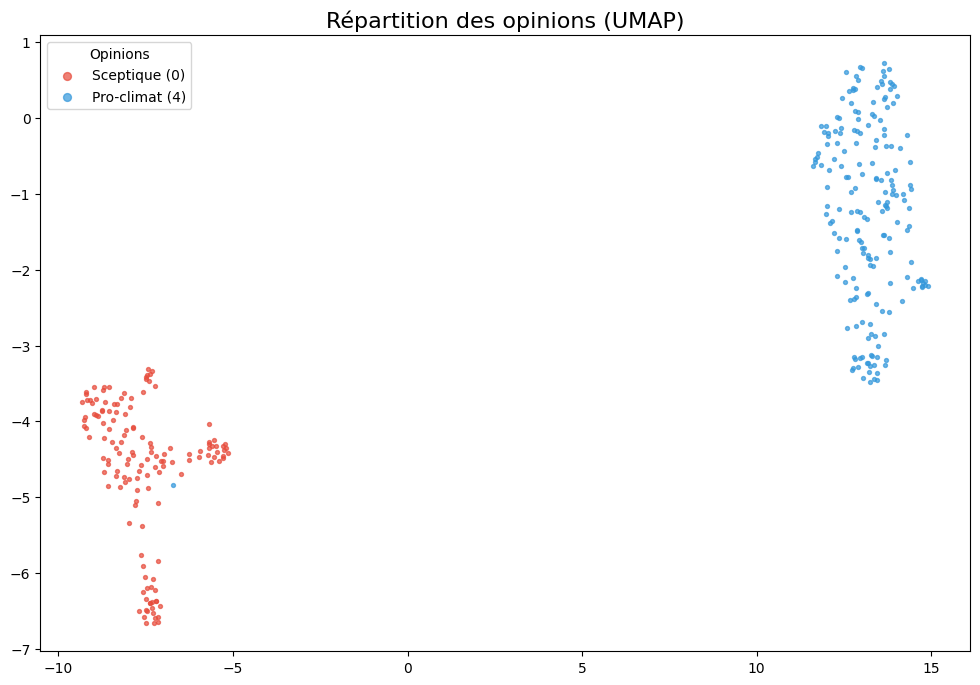

In [77]:
#suppervisé (le train)
fonctions.plot_umap_results(train_embeddingsupp,train_opinions_np)

In [14]:
# Test KNN sur UMAP Non-Supervisé
knn_unsup = KNeighborsClassifier(n_neighbors=5)
knn_unsup.fit(train_embedding, train_opinions_np)
y_pred_unsup = knn_unsup.predict(test_emb)

print("--- RÉSULTATS UMAP SUPERVISÉ ---")
print(f"Accuracy: {accuracy_score(test_opinions_np, y_pred_unsup):.4f}")
print(classification_report(test_opinions_np, y_pred_unsup))

--- RÉSULTATS UMAP SUPERVISÉ ---
Accuracy: 0.9881
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        29
           4       0.98      1.00      0.99        55

    accuracy                           0.99        84
   macro avg       0.99      0.98      0.99        84
weighted avg       0.99      0.99      0.99        84



In [79]:
#on ne fait pas ici la suppression de tous les gens dont ont connait pas l'opinion

In [80]:

liste_emb = emb.values.tolist()

train_tot, test_tot = train_test_split(liste_emb, test_size=0.20, random_state=42)
len(train_tot)


115377

In [87]:
y_list_tot = []
for node_id in train_tot:
    val = int(node_id[0] if isinstance(node_id, (list, np.ndarray)) else node_id)
    y_list_tot.append(mapping_dict.get(val, -1))

# 3. CRUCIAL : Convertir en tableau NumPy avec un type numérique précis (int64)
train_opinions_np_tot = np.array(y_list_tot, dtype=np.int64)

In [88]:
#aprestissage supervisé sans suppressin sur 80%
train_tot_ = [row[1:] for row in train_tot]
test_tot_ = [row[1:] for row in test_tot]
reducers_tot = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    random_state=42,
    target_weight=0.5  
)
train_embedding_tot = reducers_tot.fit_transform(train_tot_,y=train_opinions_np_tot)
test_emb_tot=reducers_tot.transform(test_tot_)

/home/bourenane/.local/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


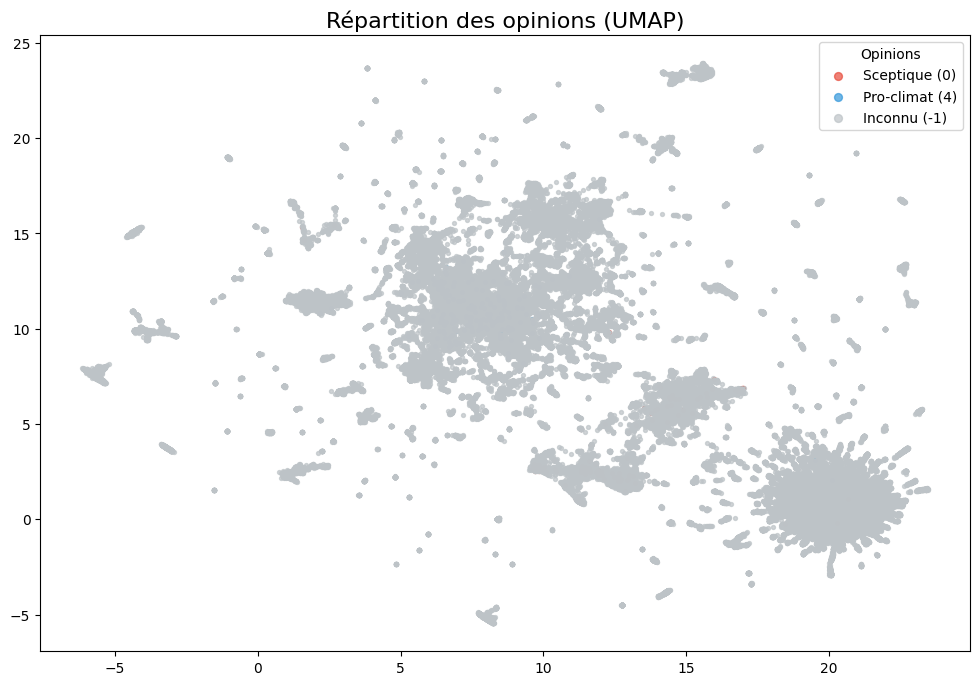

In [89]:
#supervisé (le train) avec 80% sans suppression des inconnues
fonctions.plot_umap_results(train_embedding_tot,train_opinions_np_tot)

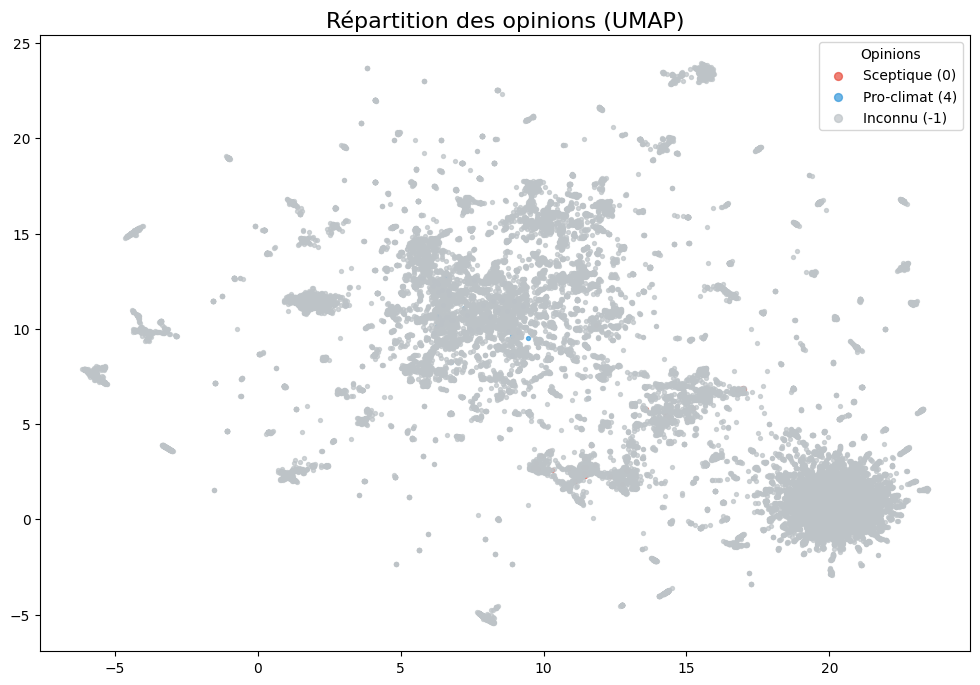

In [90]:
y_list_tot_test = []
for node_id in test_tot:
    val = int(node_id[0] if isinstance(node_id, (list, np.ndarray)) else node_id)
    y_list_tot_test.append(mapping_dict.get(val, -1))
                           
test_opinions_np_tot=np.array(y_list_tot_test, dtype=np.int64)
#supervisé (le test) avec 80% sans suppression des inconnues
fonctions.plot_umap_results(test_emb_tot,test_opinions_np_tot)

In [112]:
# Test KNN sur UMAP Non-Supervisé
knn_unsup = KNeighborsClassifier(n_neighbors=5)
knn_unsup.fit(train_embedding, train_opinions_np)
y_pred_unsup = knn_unsup.predict(test_emb)

print("--- RÉSULTATS UMAP NON-SUPERVISÉ ---")
print(f"Accuracy: {accuracy_score(test_opinions_np, y_pred_unsup):.4f}")
print(classification_report(test_opinions_np, y_pred_unsup))

--- RÉSULTATS UMAP NON-SUPERVISÉ ---
Accuracy: 0.9881
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        29
           4       0.98      1.00      0.99        55

    accuracy                           0.99        84
   macro avg       0.99      0.98      0.99        84
weighted avg       0.99      0.99      0.99        84



knn_supper=KNeighborsClassifier(n_neighbors=5)

In [93]:
knn_model=knn_supper.fit(train_embeddingsupp,train_opinions_np)

In [94]:
y_pred_sup=knn_model.predict(test_emb)

In [95]:
print(f"Précision sur les personnes connues : {accuracy_score(test_opinions_np, y_pred_sup):.2%}")

Précision sur les personnes connues : 98.81%


In [96]:
classification_report(test_opinions_np, y_pred_unsup)

'              precision    recall  f1-score   support\n\n           0       1.00      0.97      0.98        29\n           4       0.98      1.00      0.99        55\n\n    accuracy                           0.99        84\n   macro avg       0.99      0.98      0.99        84\nweighted avg       0.99      0.99      0.99        84\n'

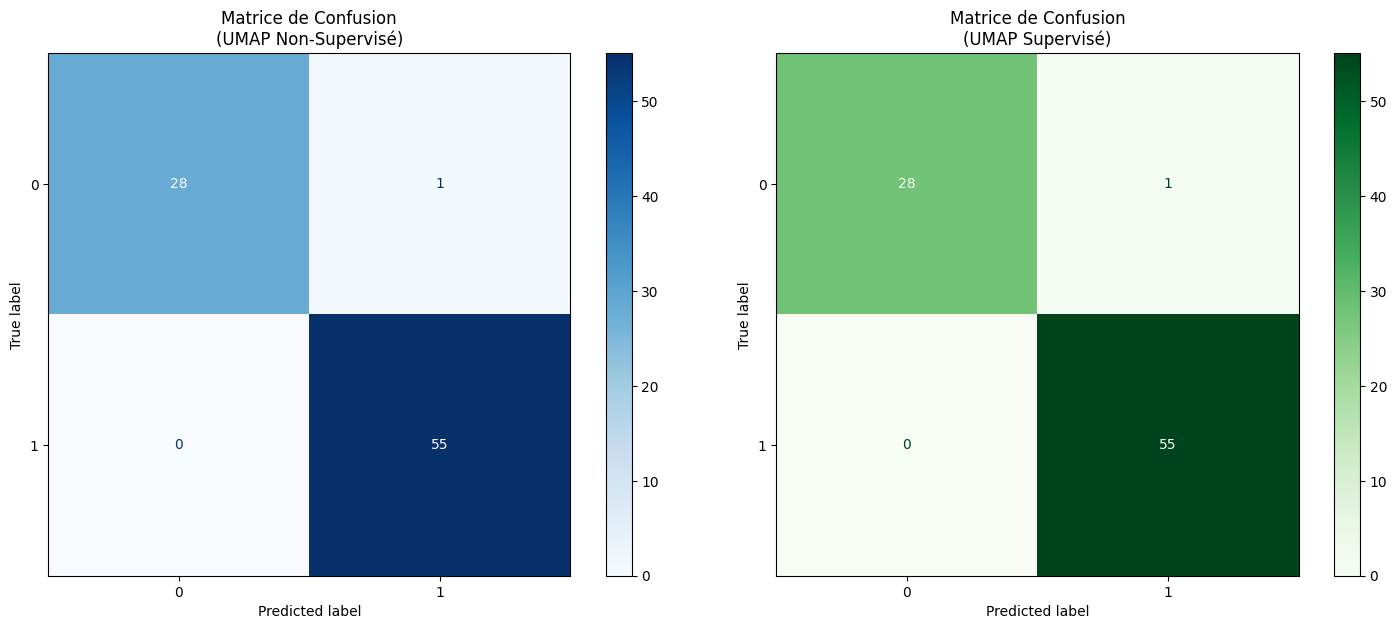

In [97]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1. Matrice de confusion pour le cas NON-SUPERVISÉ
cm_unsup = confusion_matrix(test_opinions_np, y_pred_unsup)
disp_unsup = ConfusionMatrixDisplay(confusion_matrix=cm_unsup)

# 2. Matrice de confusion pour le cas SUPERVISÉ
cm_sup = confusion_matrix(test_opinions_np, y_pred_sup)
disp_sup = ConfusionMatrixDisplay(confusion_matrix=cm_sup)

# Affichage côte à côte
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

disp_unsup.plot(ax=ax[0], cmap='Blues')
ax[0].set_title("Matrice de Confusion\n(UMAP Non-Supervisé)")

disp_sup.plot(ax=ax[1], cmap='Greens')
ax[1].set_title("Matrice de Confusion\n(UMAP Supervisé)")

plt.tight_layout()
plt.show()

In [98]:
print("Voici les différentes communautés trouvées dans le fichier :")
print(df_nodes['modularity_class'].unique())

Voici les différentes communautés trouvées dans le fichier :
[4 0]
